In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
import pandas as pd
import seaborn as sns

In [2]:
def map_type_to_club_category(type_value):
    if type_value == 1:
        return "Big clubs"
    elif type_value == 2:
        return "Medium clubs"
    elif type_value == 3:
        return "Small clubs"
    else:
        return "Unknown"
    
# Map league names based on agent_id ranges
def map_agent_to_league(agent_id):
    if 0 <= agent_id <= 19:
        return 'Premier League'
    elif 20 <= agent_id <= 39:
        return 'La Liga'
    elif 40 <= agent_id <= 59:
        return 'Serie A'
    elif 60 <= agent_id <= 77:
        return 'Bundesliga'
    elif 78 <= agent_id <= 97:
        return 'Ligue 1'
    else:
        return 'Unknown'

In [3]:
params={
        "C": 98,
        "F": 1,
        "P": 2500,
        "league_range": [(0, 97)],
        "FFP": [False, True], 
    }


results = mesa.batch_run(
    model_cls=MyModel,
    parameters = params, 
    iterations=200,
    max_steps=40,
    data_collection_period = 1,  # Collect data at each time step
    display_progress=True,
    number_processes=4 
)

results_df = pd.DataFrame(results)


100%|███████████████████████████████████████| 400/400 [1:15:01<00:00, 11.25s/it]


In [4]:
print(results_df.keys())
print('\n')
print(results_df.head())
print('\n')
print(results_df.tail())

Index(['RunId', 'iteration', 'Step', 'C', 'F', 'P', 'league_range', 'FFP',
       'Winner Club', 'Winner level', 'Season', 'Average revenue by league',
       'Total revenue by league', 'Average Transferred Value (Type 1)',
       'Average Transferred Value (Type 2)',
       'Average Transferred Value (Type 3)', 'AgentID', 'Club Revenue',
       'Team size', 'Name', 'TV', 'Type'],
      dtype='object')


   RunId  iteration  Step   C  F     P league_range    FFP Winner Club  \
0      0          0     0  98  1  2500      (0, 97)  False        None   
1      0          0     1  98  1  2500      (0, 97)  False        None   
2      0          0     1  98  1  2500      (0, 97)  False        None   
3      0          0     1  98  1  2500      (0, 97)  False        None   
4      0          0     1  98  1  2500      (0, 97)  False        None   

   Winner level  ...                            Total revenue by league  \
0           NaN  ...  {'Premier League': 6176.0, 'La Liga': 3219.5, ... 

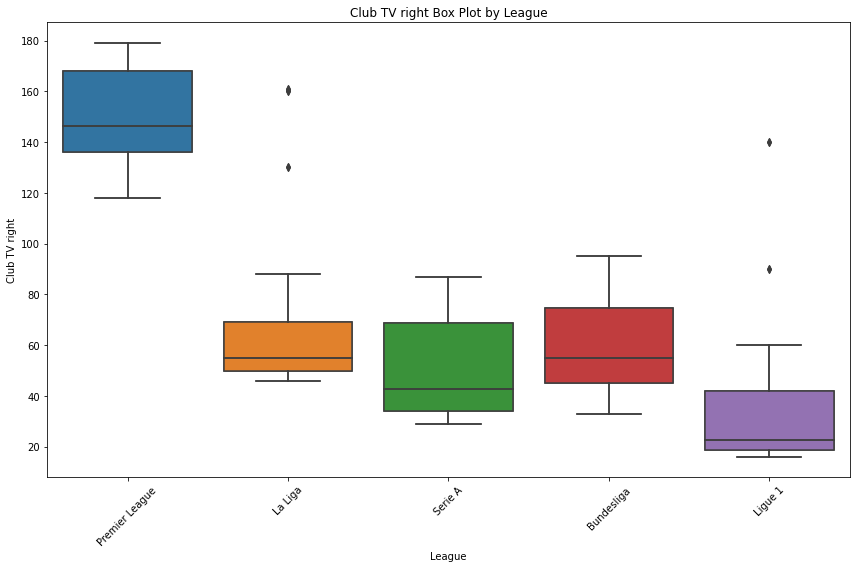

In [5]:
# Box Plot TV rights

# Assuming 'agent_id' column exists in results_df
club_df = results_df[['TV', 'Name', 'AgentID']].dropna()
club_df = club_df.head(98)

# Assign league names to the rows based on agent_id
club_df['League Name'] = club_df['AgentID'].apply(map_agent_to_league)

# Create a figure and axis
plt.figure(figsize=(12, 8))

ax = sns.boxplot(x='League Name', y='TV', data=club_df)


# Create a box plot for each league using Seaborn
sns.boxplot(x='League Name', y='TV', data=club_df)

# Set labels and title
plt.xlabel('League')
plt.ylabel('Club TV right')
plt.title('Club TV right Box Plot by League')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Calculate the IQR for each league
grouped_data = club_df.groupby('League Name')
iqr_by_league = {}
for league, data in grouped_data:
    iqr = data['TV'].quantile(0.75) - data['TV'].quantile(0.25)
    iqr_by_league[league] = iqr

    
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()



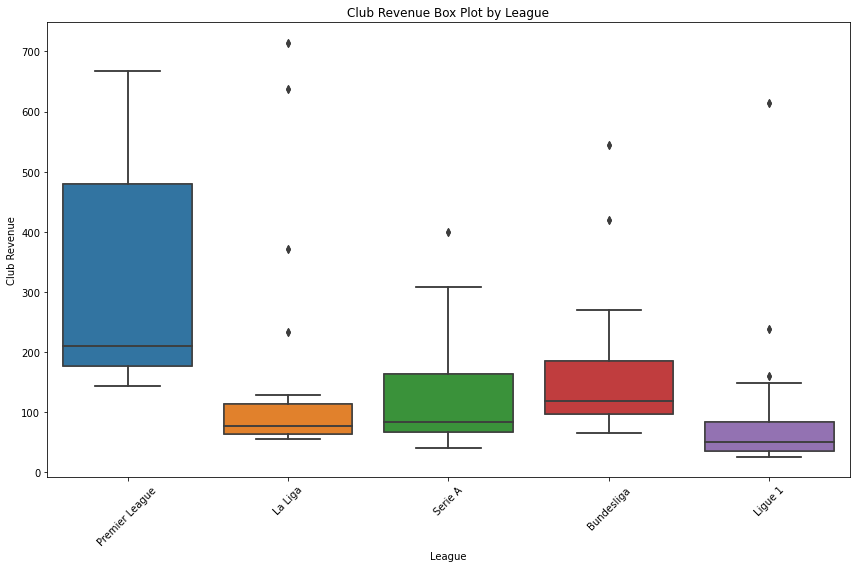

In [6]:
# Box Plot revenue

# Assuming 'agent_id' column exists in results_df
club_df = results_df[['Club Revenue', 'Name', 'AgentID']].dropna()
club_df = club_df.head(98)

# Assign league names to the rows based on agent_id
club_df['League Name'] = club_df['AgentID'].apply(map_agent_to_league)

# Create a figure and axis
plt.figure(figsize=(12, 8))

ax = sns.boxplot(x='League Name', y='Club Revenue', data=club_df)


# Create a box plot for each league using Seaborn
sns.boxplot(x='League Name', y='Club Revenue', data=club_df)

# Set labels and title
plt.xlabel('League')
plt.ylabel('Club Revenue')
plt.title('Club Revenue Box Plot by League')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Calculate the IQR for each league
grouped_data = club_df.groupby('League Name')
iqr_by_league = {}
for league, data in grouped_data:
    iqr = data['Club Revenue'].quantile(0.75) - data['Club Revenue'].quantile(0.25)
    iqr_by_league[league] = iqr

    
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()



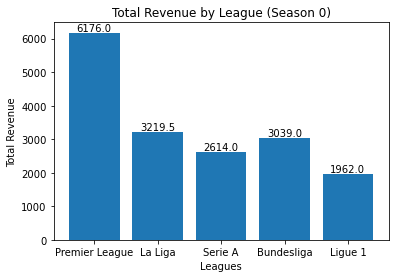

In [7]:
# Total revenue by league

# Group the data by 'Season' and 'league_range'
grouped_data = results_df.groupby(['Season', 'league_range'])

# Initialize a dictionary to store total revenue for each league
total_revenue_by_league = {}

# Iterate through the grouped data to calculate total revenue for each league in the first season
for group, data in grouped_data:
    season, league_range = group
    if season == 0:  # Check if it's the first season (season number starts from 0)
        total_revenue = data['Total revenue by league'].iloc[0]  # The total revenue is the same for all clubs in the same league and step
        for league, revenue in total_revenue.items():
            total_revenue_by_league[league] = total_revenue_by_league.get(league, 0) + revenue

# Extracting league names and revenue values
leagues = list(total_revenue_by_league.keys())
revenues = list(total_revenue_by_league.values())

# Plotting the histogram for the first season
plt.bar(leagues, revenues)
plt.xlabel('Leagues')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by League (Season 0)')

# Adding the total revenue numbers on top of each bar
for i, revenue in enumerate(revenues):
    plt.text(i, revenue, str(revenue), ha='center', va='bottom')
    
plt.show()


In [8]:
# Average team size by club

# Calculate average team size for each team type when FFP is true
average_team_size_ffp_true = results_df[results_df['FFP'] == True].groupby('Name')['Team size'].mean()

# Calculate average team size for each team type when FFP is false
average_team_size_ffp_false = results_df[results_df['FFP'] == False].groupby('Name')['Team size'].mean()

# Convert the results to DataFrames and reset index
average_team_size_ffp_true_df = average_team_size_ffp_true.reset_index()
average_team_size_ffp_true_df.columns = ['Name', 'With FFP']

average_team_size_ffp_false_df = average_team_size_ffp_false.reset_index()
average_team_size_ffp_false_df.columns = ['Name', 'Without FFP']

# Sort the DataFrames by 'Team size' column in descending order
average_team_size_ffp_true_df = average_team_size_ffp_true_df.sort_values(by='With FFP', ascending=False)
average_team_size_ffp_false_df = average_team_size_ffp_false_df.sort_values(by='Without FFP', ascending=False)

print(average_team_size_ffp_true_df.head(20))
print('\n')
print(average_team_size_ffp_false_df.head(20))


                  Name   With FFP
70         Real Madrid  22.949875
53   Manchester United  21.968750
9            Barcelona  21.153500
47           Liverpool  20.950875
66                 PSG  20.890625
52     Manchester City  20.308625
21             Chelsea  20.267500
11       Bayern Munich  19.956625
3              Arsenal  19.301375
86           Tottenham  18.830500
25            Dortmund  18.225000
40            Juventus  17.997250
7   Atletico de Madrid  17.173625
39         Inter Milan  15.808500
0             AC Milan  15.568250
95            West Ham  14.389500
67          RB Leipzig  14.289625
62           Newcastle  13.772875
54          Marseilles  13.578125
45           Leicester  13.524000


                  Name  Without FFP
53   Manchester United    22.253500
70         Real Madrid    22.171500
66                 PSG    22.016750
52     Manchester City    21.483375
9            Barcelona    21.288750
21             Chelsea    20.779875
47           Liverpool    20.741

In [9]:
# Average team size by clubs category

# Calculate average team size for each team type when FFP is true
average_team_size_ffp_true = results_df[results_df['FFP'] == True].groupby('Type')['Team size'].mean()

# Calculate average team size for each team type when FFP is false
average_team_size_ffp_false = results_df[results_df['FFP'] == False].groupby('Type')['Team size'].mean()

# Convert the results to DataFrames and reset index
average_team_size_ffp_true_df = average_team_size_ffp_true.reset_index()
average_team_size_ffp_true_df['Type'] = average_team_size_ffp_true_df['Type'].apply(map_type_to_club_category)
average_team_size_ffp_true_df.columns = ['Type', 'With FFP']

average_team_size_ffp_false_df = average_team_size_ffp_false.reset_index()
average_team_size_ffp_false_df['Type'] = average_team_size_ffp_false_df['Type'].apply(map_type_to_club_category)
average_team_size_ffp_false_df.columns = ['Type', 'Without FFP']

print(average_team_size_ffp_true_df)
print('\n')
print(average_team_size_ffp_false_df)


           Type   With FFP
0     Big clubs  19.423392
1  Medium clubs  12.760742
2   Small clubs  12.162804


           Type  Without FFP
0     Big clubs    19.766417
1  Medium clubs    12.736367
2   Small clubs    12.055792


In [10]:
# Average transfer value by category of clubs

# Group the DataFrame by 'FFP' and calculate the mean of the relevant columns for each club type
grouped_avg_transferred_values = results_df.groupby(['FFP'])[
    ["Average Transferred Value (Type 1)",
    "Average Transferred Value (Type 2)",
    "Average Transferred Value (Type 3)"]
].mean()

# Print the calculated average transferred values for each FFP condition
for ffp, avg_values in grouped_avg_transferred_values.iterrows():
    print(f"FFP: {ffp}")
    for col_name, avg_value in avg_values.items():
        club_type_str = col_name.split(" ")[-1]  # Extract the club type string from the column name
        club_type = int(club_type_str.replace("(", "").replace(")", ""))  # Remove parentheses and convert to int
        club_category = map_type_to_club_category(club_type)
        print(f"  Average Transfer Value for {club_category}: {avg_value:.2f}")


FFP: False
  Average Transfer Value for Big clubs: 93.63
  Average Transfer Value for Medium clubs: 38.83
  Average Transfer Value for Small clubs: 13.95
FFP: True
  Average Transfer Value for Big clubs: 69.79
  Average Transfer Value for Medium clubs: 27.83
  Average Transfer Value for Small clubs: 13.15


In [11]:
# Winners dataframe

# winners_df = results_df[['Winner Club', 'Season','RunId', "Team size"]].set_index('Season')
winners_df = results_df[['Winner Club', 'Winner level', 'Season', 'AgentID', 'RunId', 'Team size', 'FFP', 'Name', 'Type' ]]
winners_df = winners_df[winners_df['Winner Club'].notnull()]
winners_df['League Name'] = winners_df['AgentID'].apply(map_agent_to_league)

winners_df = winners_df[winners_df['Winner Club'] == winners_df['Name']]

# Group by 'RunId' and 'Season', and get the first entry for each group (which corresponds to the winner)
winners_df = winners_df.groupby(['RunId', 'Season']).first()

winners_df['Club Category'] = winners_df['Type'].apply(map_type_to_club_category)


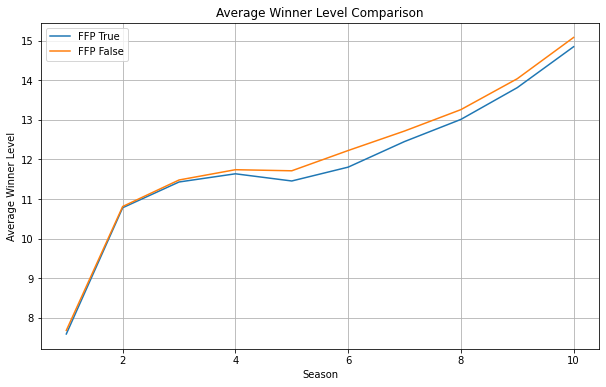

In [12]:
# Line chart for the evolution of winners' level

# Filter winners_df for FFP true and false cases
winners_ffp_true = winners_df[winners_df['FFP'] == True]
winners_ffp_false = winners_df[winners_df['FFP'] == False]

# Group winners by Season and calculate average winner level for each season
average_winner_level_ffp_true = winners_ffp_true.groupby('Season')['Winner level'].mean()
average_winner_level_ffp_false = winners_ffp_false.groupby('Season')['Winner level'].mean()

# Create line charts
plt.figure(figsize=(10, 6))
plt.plot(average_winner_level_ffp_true.index, average_winner_level_ffp_true, label='FFP True')
plt.plot(average_winner_level_ffp_false.index, average_winner_level_ffp_false, label='FFP False')
plt.xlabel('Season')
plt.ylabel('Average Winner Level')
plt.title('Average Winner Level Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Team size of winners

# Group by 'Winner Club' and calculate the average team size and count the number of times each club won when FFP is true
average_team_size_df_ffp_true = winners_ffp_true.groupby('Winner Club').agg(
    {"Team size": "mean", "Winner Club": "size"}).rename(columns={'Team size': 'Average Team Size (FFP True)',
                                                                  'Winner Club': 'Number of Wins'})

# Sort the DataFrame by the average team size in descending order
average_team_size_df_ffp_true = average_team_size_df_ffp_true.sort_values(by='Average Team Size (FFP True)',
                                                                          ascending=False)


# Group by 'Winner Club' and calculate the average team size and count the number of times each club won when FFP is false
average_team_size_df_ffp_false = winners_ffp_false.groupby('Winner Club').agg(
    {"Team size": "mean", "Winner Club": "size"}).rename(columns={'Team size': 'Average Team Size (FFP False)',
                                                                   'Winner Club': 'Number of Wins'})

# Sort the DataFrame by the average team size in descending order
average_team_size_df_ffp_false = average_team_size_df_ffp_false.sort_values(by='Average Team Size (FFP False)',
                                                                            ascending=False)

# Display the DataFrames
print(average_team_size_df_ffp_true)
print('\n')
print(average_team_size_df_ffp_false)


                    Average Team Size (FFP True)  Number of Wins
Winner Club                                                     
Sevilla                                26.000000               2
RB Leipzig                             25.000000               2
Newcastle                              25.000000               2
West Ham                               24.750000               8
Manchester United                      24.507092             282
Real Madrid                            24.504249             353
Barcelona                              24.366337             202
Liverpool                              24.234742             213
PSG                                    24.149733             187
Dortmund                               24.133333              60
Manchester City                        23.849315             146
AC Milan                               23.777778               9
Bayern Munich                          23.617647             136
Inter Milan              

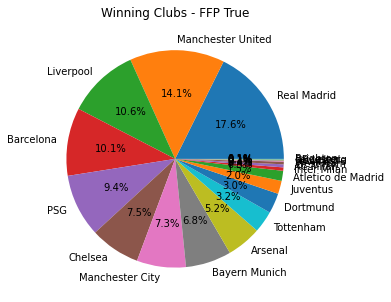

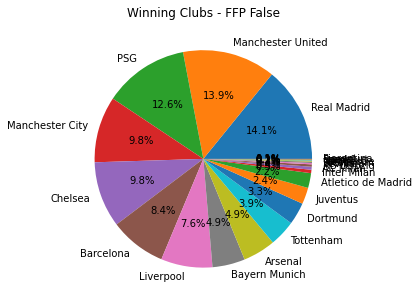

In [14]:
# Pie chart of winners club

# Reset the index of the DataFrame
winners_df_reset = winners_df.reset_index()

# Filter DataFrame based on FFP True
data_ffp_true = winners_df_reset[winners_df_reset['FFP'] == True]['Winner Club'].value_counts()

# Filter DataFrame based on FFP False
data_ffp_false = winners_df_reset[winners_df_reset['FFP'] == False]['Winner Club'].value_counts()

# Plotting Pie Chart for FFP True
plt.figure(figsize=(10, 5))
plt.pie(data_ffp_true, labels=data_ffp_true.index, autopct='%1.1f%%')
plt.title("Winning Clubs - FFP True")
plt.show()

# Plotting Pie Chart for FFP False
plt.figure(figsize=(10, 5))
plt.pie(data_ffp_false, labels=data_ffp_false.index, autopct='%1.1f%%')
plt.title("Winning Clubs - FFP False")
plt.show()


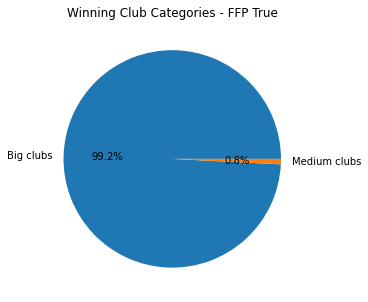

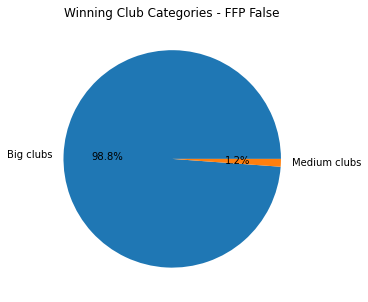

In [15]:
# Pie chart of winners club category

# Reset the index of the DataFrame
winners_df_reset = winners_df.reset_index()

# Filter DataFrame based on FFP True
data_ffp_true = winners_df_reset[winners_df_reset['FFP'] == True]['Club Category'].value_counts()

# Filter DataFrame based on FFP False
data_ffp_false = winners_df_reset[winners_df_reset['FFP'] == False]['Club Category'].value_counts()

# Plotting Pie Chart for FFP True
plt.figure(figsize=(10, 5))
plt.pie(data_ffp_true, labels=data_ffp_true.index, autopct='%1.1f%%')
plt.title("Winning Club Categories - FFP True")
plt.show()

# Plotting Pie Chart for FFP False
plt.figure(figsize=(10, 5))
plt.pie(data_ffp_false, labels=data_ffp_false.index, autopct='%1.1f%%')
plt.title("Winning Club Categories - FFP False")
plt.show()

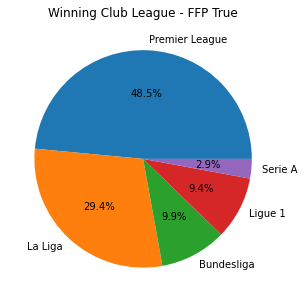

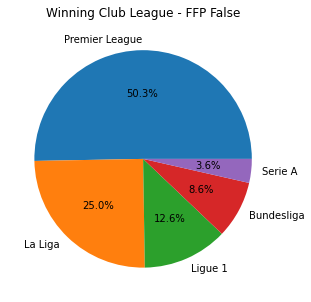

      RunId  Season      Winner Club  Winner level  AgentID  Team size    FFP  \
0         0       1    Bayern Munich        7.8392     60.0       25.0  False   
1         0       2              PSG       10.9400     78.0       25.0  False   
2         0       3         Dortmund       10.9016     61.0       26.0  False   
3         0       4         Dortmund        9.8604     61.0       14.0  False   
4         0       5  Manchester City        9.0800      0.0       25.0  False   
...     ...     ...              ...           ...      ...        ...    ...   
3995    399       6        Barcelona       13.3764     21.0       21.0   True   
3996    399       7        Barcelona       14.8800     21.0       25.0   True   
3997    399       8        Barcelona       13.5408     21.0       21.0   True   
3998    399       9         West Ham       12.9200      6.0       25.0   True   
3999    399      10        Liverpool       14.2816      1.0       25.0   True   

                 Name  Type

In [16]:
# Pie chart of winners club category

# Reset the index of the DataFrame
winners_df_reset = winners_df.reset_index()

# Filter DataFrame based on FFP True
data_ffp_true = winners_df_reset[winners_df_reset['FFP'] == True]['League Name'].value_counts()

# Filter DataFrame based on FFP False
data_ffp_false = winners_df_reset[winners_df_reset['FFP'] == False]['League Name'].value_counts()

# Plotting Pie Chart for FFP True
plt.figure(figsize=(10, 5))
plt.pie(data_ffp_true, labels=data_ffp_true.index, autopct='%1.1f%%')
plt.title("Winning Club League - FFP True")
plt.show()

# Plotting Pie Chart for FFP False
plt.figure(figsize=(10, 5))
plt.pie(data_ffp_false, labels=data_ffp_false.index, autopct='%1.1f%%')
plt.title("Winning Club League - FFP False")
plt.show()

